In [1]:
import tensorflow as tf
print(tf.__version__)
!python --version

2025-07-31 05:07:52.012534: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.16.2
Python 3.11.0


## General Attention Mechanism

- Reference: https://machinelearningmastery.com/the-attention-mechanism-from-scratch/

In [2]:
from numpy import array
from numpy import random
from scipy.special import softmax
 
# encoder representations (3 dimensional) of four different words
word_1 = array([1, 0, 0])
word_2 = array([0, 1, 0])
word_3 = array([1, 1, 0])
word_4 = array([0, 0, 1])

# stacking the word embeddings into a single array
words = array([word_1, word_2, word_3, word_4])
print(words.shape)

(4, 3)


In [3]:
# generating the weight matrices
random.seed(42)
W_Q = random.randint(3, size=(3, 3))
W_K = random.randint(3, size=(3, 3))
W_V = random.randint(3, size=(3, 3))
print(W_K.shape)

(3, 3)


In [4]:
# generating the queries, keys and values
Q = words @ W_Q
K = words @ W_K
V = words @ W_V
print(Q.shape, K.shape, V.shape)

(4, 3) (4, 3) (4, 3)


In [5]:
# scoring the query vectors against all key vectors
scores = Q @ K.transpose()
print("Scores shaoe: ", scores.shape)

# computing the weights by a softmax operation
weights = softmax(scores / K.shape[1] ** 0.5, axis=1)
print("Weights shape: ", weights.shape)
 
# computing the attention by a weighted sum of the value vectors
attention = weights @ V
print("Attention Shape: ", attention.shape)
 
print(attention)

Scores shaoe:  (4, 4)
Weights shape:  (4, 4)
Attention Shape:  (4, 3)
[[0.98522025 1.74174051 0.75652026]
 [0.90965265 1.40965265 0.5       ]
 [0.99851226 1.75849334 0.75998108]
 [0.99560386 1.90407309 0.90846923]]


## Implementing the Scaled Dot-Product Attention from Scratch in tf and keras

 - Reference: https://machinelearningmastery.com/how-to-implement-scaled-dot-product-attention-from-scratch-in-tensorflow-and-keras/

In [6]:
from tensorflow import matmul, math, cast, float32
from keras import Layer, activations

# Implementing the Scaled-Dot Product Attention
class DotProductAttention(Layer):
    def __init__(self, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
 
    def call(self, queries, keys, values, d_k, mask=None):
        # Scoring the queries against the keys after transposing the latter, and scaling
        scores = matmul(queries, keys, transpose_b=True) / math.sqrt(cast(d_k, float32)) # shape would be: (64, 5, 5)
 
        # Apply mask to the attention scores
        if mask is not None:
            scores += -1e9 * mask
 
        # Computing the weights by a softmax operation
        weights = activations.softmax(scores, axis=-1) # shape would be: (64, 5, 5)
 
        # Computing the attention by a weighted sum of the value vectors
        return matmul(weights, values) # shape would be: (64, 5, 64)

In [7]:
from numpy import random
import tensorflow as tf
 
input_seq_length = 5  # Maximum length of the input sequence
d_k = tf.constant(64)  # Dimensionality of the linearly projected queries and keys
d_v = 64  # Dimensionality of the linearly projected values
batch_size = 64  # Batch size from the training process
 
queries = random.random((batch_size, input_seq_length, d_k)) # Shape would be: (64, 5, 64)
keys = random.random((batch_size, input_seq_length, d_k)) # Shape would be: (64, 5, 64)
values = random.random((batch_size, input_seq_length, d_v)) # Shape would be: (64, 5, 64)
 
attention = DotProductAttention()
attention(queries, keys, values, d_k).shape


TensorShape([64, 5, 64])

## Implement Multi-Head Attention from Scratch in TensorFlow and Keras

- Reference: https://machinelearningmastery.com/how-to-implement-multi-head-attention-from-scratch-in-tensorflow-and-keras/

### Dot Product layer

In [8]:
from tensorflow import math, matmul, reshape, shape, transpose, cast, float32
from keras import layers, Layer, activations

# Implementing the Scaled-Dot Product Attention
class DotProductAttention(Layer):
    def __init__(self, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)

    def call(self, queries, keys, values, d_k, mask=None):
        # Scoring the queries against the keys after transposing the latter, and scaling
        # print(queries.shape, keys.shape)
        scores = matmul(queries, keys, transpose_b=True) / math.sqrt(cast(d_k, float32))
        # print(scores.shape)

        # Apply mask to the attention scores
        if mask is not None:
            scores += -1e9 * mask
            # print(scores.shape)

        # Computing the weights by a softmax operation
        weights = activations.softmax(scores)

        # Computing the attention by a weighted sum of the value vectors
        return matmul(weights, values)

### MultiHeadAttention Layer

In [9]:
# Implementing the Multi-Head Attention
class MultiHeadAttention(Layer):
    def __init__(self, h, d_k, d_v, d_model, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.attention = DotProductAttention()  # Scaled dot product attention
        self.heads = h  # Number of attention heads to use
        self.d_k = d_k  # Dimensionality of the linearly projected queries and keys
        self.d_v = d_v  # Dimensionality of the linearly projected values
        self.d_model = d_model  # Dimensionality of the model
        self.W_q = layers.Dense(d_k)  # Learned projection matrix for the queries
        self.W_k = layers.Dense(d_k)  # Learned projection matrix for the keys
        self.W_v = layers.Dense(d_v)  # Learned projection matrix for the values
        self.W_o = layers.Dense(d_model)  # Learned projection matrix for the multi-head output

    def reshape_tensor(self, x, heads, flag):
        if flag:
            # Tensor shape after reshaping and transposing: (batch_size, heads, seq_length, -1)
            x = reshape(x, shape=(shape(x)[0], shape(x)[1], heads, -1)) # shape here: (batch_size, seq_length, heads, , -1)
            x = transpose(x, perm=(0, 2, 1, 3))
        else:
            # Reverting the reshaping and transposing operations: (batch_size, seq_length, d_k)
            x = transpose(x, perm=(0, 2, 1, 3))
            x = reshape(x, shape=(shape(x)[0], shape(x)[1], -1))
        return x

    def call(self, queries, keys, values, mask=None):
        # Rearrange the queries to be able to compute all heads in parallel
        q_reshaped = self.reshape_tensor(self.W_q(queries), self.heads, True) # Shape of self.W_q(queries): (64, 5, 64)
        # Resulting tensor shape: (batch_size, heads, input_seq_length, -1)

        # Rearrange the keys to be able to compute all heads in parallel
        k_reshaped = self.reshape_tensor(self.W_k(keys), self.heads, True)
        # Resulting tensor shape: (batch_size, heads, input_seq_length, -1)

        # Rearrange the values to be able to compute all heads in parallel
        v_reshaped = self.reshape_tensor(self.W_v(values), self.heads, True)
        # Resulting tensor shape: (batch_size, heads, input_seq_length, -1)

        # Compute the multi-head attention output using the reshaped queries, keys and values
        o_reshaped = self.attention(q_reshaped, k_reshaped, v_reshaped, tf.constant(self.d_k), mask)
        # Resulting tensor shape: (batch_size, heads, input_seq_length, -1)

        # Rearrange back the output into concatenated form
        output = self.reshape_tensor(o_reshaped, self.heads, False)
        # Resulting tensor shape: (batch_size, input_seq_length, d_v)

        # Apply one final linear projection to the output to generate the multi-head attention
        # Resulting tensor shape: (batch_size, input_seq_length, d_model)
        return self.W_o(output)

## Why do we use projection matrices in multi-head attention and not scaled-dot product attention?

## Projection Matrices in Multi-Head Attention vs Scaled Dot-Product Attention

The key distinction is that **multi-head attention** builds upon basic scaled dot-product attention by adding projection matrices to create multiple parallel attention mechanisms.

### Scaled Dot-Product Attention

Scaled dot-product attention is the fundamental attention operation:
- Uses query (Q), key (K), and value (V) matrices directly
- Formula: `Attention(Q,K,V) = softmax(QK^T/√d_k)V`
- No projection matrices - works with the input matrices as they are

### Multi-Head Attention

Multi-head attention adds projection matrices for several important reasons:

1. **Multiple representation subspaces** - Each head can focus on different aspects of the input by projecting into separate subspaces
   ```
   head_i = Attention(QW_i^Q, KW_i^K, VW_i^V)
   ```

2. **Feature diversity** - Different heads can learn to attend to different patterns (syntactic relationships, semantic similarities, etc.)

3. **Parallel processing** - Multiple attention operations happen simultaneously with different projections

4. **Improved model capacity** - The projection matrices are learnable parameters that increase the model's expressiveness

Without these projection matrices, we would essentially just have a single attention mechanism rather than the parallel specialized attention mechanisms that make transformers so powerful.

In [10]:
from numpy import random

input_seq_length = 5  # Maximum length of the input sequence
h = 8  # Number of self-attention heads
d_k = 64  # Dimensionality of the linearly projected queries and keys
d_v = 64  # Dimensionality of the linearly projected values
d_model = 512  # Dimensionality of the model sub-layers' outputs
batch_size = 64  # Batch size from the training process

queries = random.random((batch_size, input_seq_length, d_k))
keys = random.random((batch_size, input_seq_length, d_k))
values = random.random((batch_size, input_seq_length, d_v))

multihead_attention = MultiHeadAttention(h, d_k, d_v, d_model)
multihead_attention(queries, keys, values).shape

TensorShape([64, 5, 512])

## Positional Encoding Matrix from scratch
- Reference 1: https://machinelearningmastery.com/a-gentle-introduction-to-positional-encoding-in-transformer-models-part-1/
- Reference 2: https://machinelearningmastery.com/the-transformer-positional-encoding-layer-in-keras-part-2/

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def getPositionEncoding(seq_len, d, n=10000):
    P = np.zeros((seq_len, d))
    for k in range(seq_len):
        for i in np.arange(int(d/2)):
            denominator = np.power(n, 2*i/d)
            P[k, 2*i] = np.sin(k/denominator)
            P[k, 2*i+1] = np.cos(k/denominator)
    return P

P = getPositionEncoding(seq_len=4, d=4, n=100)
print(P)

[[ 0.          1.          0.          1.        ]
 [ 0.84147098  0.54030231  0.09983342  0.99500417]
 [ 0.90929743 -0.41614684  0.19866933  0.98006658]
 [ 0.14112001 -0.9899925   0.29552021  0.95533649]]


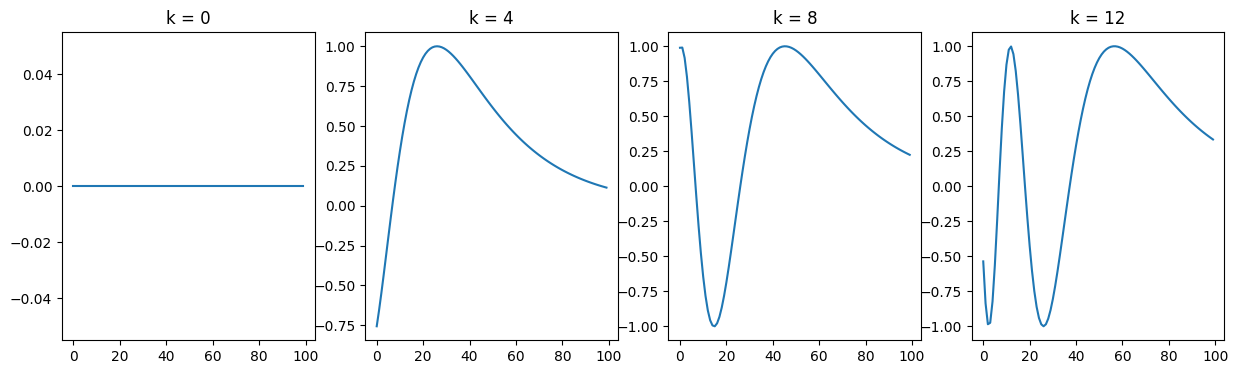

In [12]:
def plotSinusoid(k, d=512, n=10000):
    x = np.arange(0, 100, 1)
    denominator = np.power(n, 2*x/d)
    y = np.sin(k/denominator)
    plt.plot(x, y)
    plt.title('k = ' + str(k))

fig = plt.figure(figsize=(15, 4))    
for i in range(4):
    plt.subplot(141 + i)
    plotSinusoid(i*4)

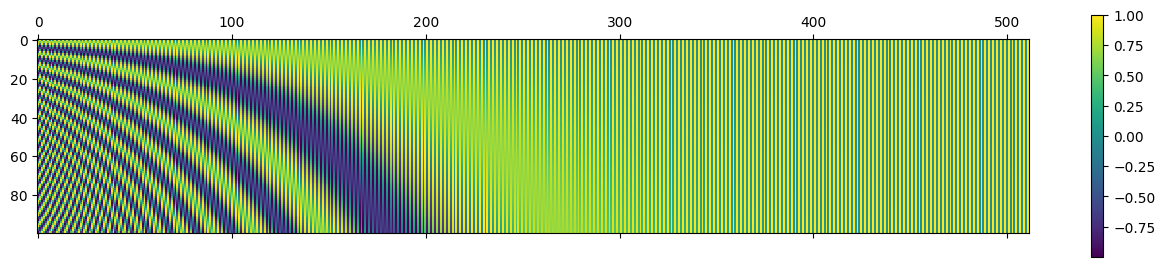

In [13]:
P = getPositionEncoding(seq_len=100, d=512, n=10000)
cax = plt.matshow(P)
plt.gcf().colorbar(cax);

In [14]:
from tensorflow import convert_to_tensor, string
from tensorflow.keras.layers import TextVectorization, Embedding, Layer
from tensorflow.data import Dataset
import numpy as np
import matplotlib.pyplot as plt

### Text Vectorization

In [15]:
output_sequence_length = 5
vocab_size = 10
sentences = [["I am a robot"], ["you too robot"]]
sentence_data = Dataset.from_tensor_slices(sentences)
# Create the TextVectorization layer
vectorize_layer = TextVectorization(
                  output_sequence_length=output_sequence_length,
                  max_tokens=vocab_size
                  )
# Train the layer to create a dictionary
vectorize_layer.adapt(sentence_data)
# Convert all sentences to tensors
word_tensors = convert_to_tensor(sentences, dtype=tf.string)
# Use the word tensors to get vectorized phrases
vectorized_words = vectorize_layer(word_tensors)
print("Vocabulary: ", vectorize_layer.get_vocabulary())
print("Vectorized words: ", vectorized_words)

Vocabulary:  ['', '[UNK]', 'robot', 'you', 'too', 'i', 'am', 'a']
Vectorized words:  tf.Tensor(
[[5 6 7 2 0]
 [3 4 2 0 0]], shape=(2, 5), dtype=int64)


2025-07-31 05:07:59.142684: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### The Word Embeddings

In [16]:
output_length = 6
word_embedding_layer = Embedding(vocab_size, output_length)
embedded_words = word_embedding_layer(vectorized_words)
print(embedded_words.shape)

(2, 5, 6)


### The Position Embeddings

In [17]:
position_embedding_layer = Embedding(output_sequence_length, output_length)
position_indices = tf.range(output_sequence_length)
print(position_indices)
embedded_indices = position_embedding_layer(position_indices)
print(embedded_indices.shape)

tf.Tensor([0 1 2 3 4], shape=(5,), dtype=int32)
(5, 6)


In [18]:
final_output_embedding = embedded_words + embedded_indices
print("Final output: ", final_output_embedding.shape)

Final output:  (2, 5, 6)


### SubClassing the Keras Embedding Layer

In [19]:
class PositionEmbeddingLayer(Layer):
    def __init__(self, sequence_length, vocab_size, output_dim, **kwargs):
        super(PositionEmbeddingLayer, self).__init__(**kwargs)
        self.word_embedding_layer = Embedding(input_dim=vocab_size, output_dim=output_dim)
        self.position_embedding_layer = Embedding(input_dim=sequence_length, output_dim=output_dim)

    def call(self, inputs):        
        position_indices = tf.range(tf.shape(inputs)[-1])
        embedded_words = self.word_embedding_layer(inputs)
        print("PositionEmbeddingLayer-embedded_words", embedded_words.shape)
        embedded_indices = self.position_embedding_layer(position_indices)
        print("PositionEmbeddingLayer-embedded_indices", embedded_indices.shape)
        return embedded_words + embedded_indices

In [20]:
output_sequence_length = 5
vocab_size = 10
output_length = 6
my_embedding_layer = PositionEmbeddingLayer(output_sequence_length, vocab_size, output_length)
embedded_layer_output = my_embedding_layer(vectorized_words)
print("Output from my_embedded_layer: ", embedded_layer_output.shape)

PositionEmbeddingLayer-embedded_words (2, 5, 6)
PositionEmbeddingLayer-embedded_indices (5, 6)
PositionEmbeddingLayer-embedded_words (2, 5, 6)
PositionEmbeddingLayer-embedded_indices (5, 6)
Output from my_embedded_layer:  (2, 5, 6)


### Positional Encoding in Transformers: Attention Is All You Need

In [21]:
class PositionEmbeddingFixedWeights(Layer):
    def __init__(self, sequence_length, vocab_size, output_dim, **kwargs):
        super(PositionEmbeddingFixedWeights, self).__init__(**kwargs)
        # word_embedding_matrix = self.get_position_encoding(vocab_size, output_dim) 
        # print("PositionEmbeddingFixedWeights-word_embedding_matrix", word_embedding_matrix.shape)  
        position_embedding_matrix = self.get_position_encoding(sequence_length, output_dim) 
        print("PositionEmbeddingFixedWeights-position_embedding_matrix", position_embedding_matrix.shape)                                         
        self.word_embedding_layer = Embedding(
            input_dim=vocab_size, output_dim=output_dim,
            # weights=[word_embedding_matrix],
            trainable=False
        )
        self.position_embedding_layer = Embedding(
            input_dim=sequence_length, output_dim=output_dim,
            weights=[position_embedding_matrix],
            trainable=False
        )
             
    def get_position_encoding(self, seq_len, d, n=10000):
        P = np.zeros((seq_len, d))
        for k in range(seq_len):
            for i in np.arange(int(d/2)):
                denominator = np.power(n, 2*i/d)
                P[k, 2*i] = np.sin(k/denominator)
                P[k, 2*i+1] = np.cos(k/denominator)
        return P

    def call(self, inputs):        
        position_indices = tf.range(tf.shape(inputs)[-1])
        embedded_words = self.word_embedding_layer(inputs)
        print("PositionEmbeddingFixedWeights-embedded_words", embedded_words.shape)
        embedded_indices = self.position_embedding_layer(position_indices)
        print("PositionEmbeddingFixedWeights-embedded_indices", embedded_indices.shape)
        return embedded_words + embedded_indices

In [22]:
output_sequence_length = 5
vocab_size = 10
output_length = 6
attnisallyouneed_embedding = PositionEmbeddingFixedWeights(output_sequence_length, vocab_size, output_length)
attnisallyouneed_output = attnisallyouneed_embedding(vectorized_words)
print("Output from my_embedded_layer: ", attnisallyouneed_output.shape)

PositionEmbeddingFixedWeights-position_embedding_matrix (5, 6)
PositionEmbeddingFixedWeights-embedded_words (2, 5, 6)
PositionEmbeddingFixedWeights-embedded_indices (5, 6)
PositionEmbeddingFixedWeights-embedded_words (2, 5, 6)
PositionEmbeddingFixedWeights-embedded_indices (5, 6)
Output from my_embedded_layer:  (2, 5, 6)


### Visualizing the Final Embedding

In [23]:
technical_phrase = "to understand machine learning algorithms you need" +\
                   " to understand concepts such as gradient of a function "+\
                   "Hessians of a matrix and optimization etc"
wise_phrase = "patrick henry said give me liberty or give me death "+\
              "when he addressed the second virginia convention in march"

total_vocabulary = 200
sequence_length = 20
final_output_len = 50
phrase_vectorization_layer = TextVectorization(
                  output_sequence_length=sequence_length,
                  max_tokens=total_vocabulary)
# Learn the dictionary
phrase_vectorization_layer.adapt([technical_phrase, wise_phrase])
print("Vocabulary: ", phrase_vectorization_layer.get_vocabulary())
print("Len of vocabulary: ", len(phrase_vectorization_layer.get_vocabulary()))
# Convert all sentences to tensors
phrase_tensors = convert_to_tensor([technical_phrase, wise_phrase], 
                                   dtype=tf.string)
print("phrase_tensors: ", phrase_tensors)
# Use the word tensors to get vectorized phrases
vectorized_phrases = phrase_vectorization_layer(phrase_tensors)

print("vectorized_phrases: ", vectorized_phrases)

random_weights_embedding_layer = PositionEmbeddingLayer(sequence_length, 
                                                        total_vocabulary,
                                                        final_output_len)
fixed_weights_embedding_layer = PositionEmbeddingFixedWeights(sequence_length, 
                                                        total_vocabulary,
                                                        final_output_len)
random_embedding = random_weights_embedding_layer(vectorized_phrases)
print("random_embedding shape: ", random_embedding.shape)
fixed_embedding = fixed_weights_embedding_layer(vectorized_phrases)
print("fixed_embedding shape: ", fixed_embedding.shape)

Vocabulary:  ['', '[UNK]', 'understand', 'to', 'of', 'me', 'give', 'a', 'you', 'when', 'virginia', 'the', 'such', 'second', 'said', 'patrick', 'or', 'optimization', 'need', 'matrix', 'march', 'machine', 'liberty', 'learning', 'in', 'hessians', 'henry', 'he', 'gradient', 'function', 'etc', 'death', 'convention', 'concepts', 'as', 'and', 'algorithms', 'addressed']
Len of vocabulary:  38
phrase_tensors:  tf.Tensor(
[b'to understand machine learning algorithms you need to understand concepts such as gradient of a function Hessians of a matrix and optimization etc'
 b'patrick henry said give me liberty or give me death when he addressed the second virginia convention in march'], shape=(2,), dtype=string)
vectorized_phrases:  tf.Tensor(
[[ 3  2 21 23 36  8 18  3  2 33 12 34 28  4  7 29 25  4  7 19]
 [15 26 14  6  5 22 16  6  5 31  9 27 37 11 13 10 32 24 20  0]], shape=(2, 20), dtype=int64)
PositionEmbeddingFixedWeights-position_embedding_matrix (20, 50)
PositionEmbeddingLayer-embedded_words 

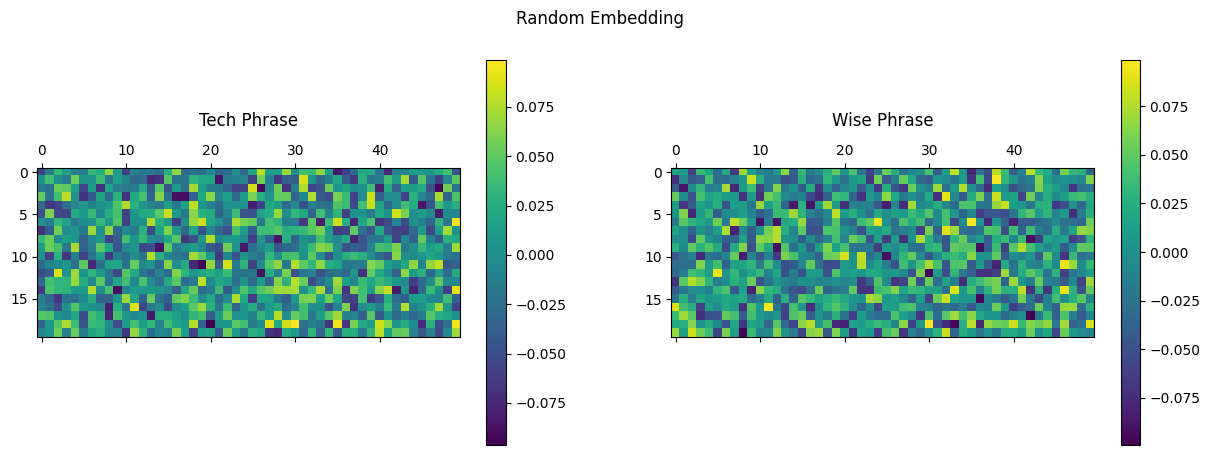

In [24]:
fig = plt.figure(figsize=(15, 5))    
title = ["Tech Phrase", "Wise Phrase"]
for i in range(2):
    ax = plt.subplot(1, 2, 1+i)
    matrix = tf.reshape(random_embedding[i, :, :], (sequence_length, final_output_len))
    cax = ax.matshow(matrix)
    plt.gcf().colorbar(cax)   
    plt.title(title[i], y=1.2)
fig.suptitle("Random Embedding")
plt.show()

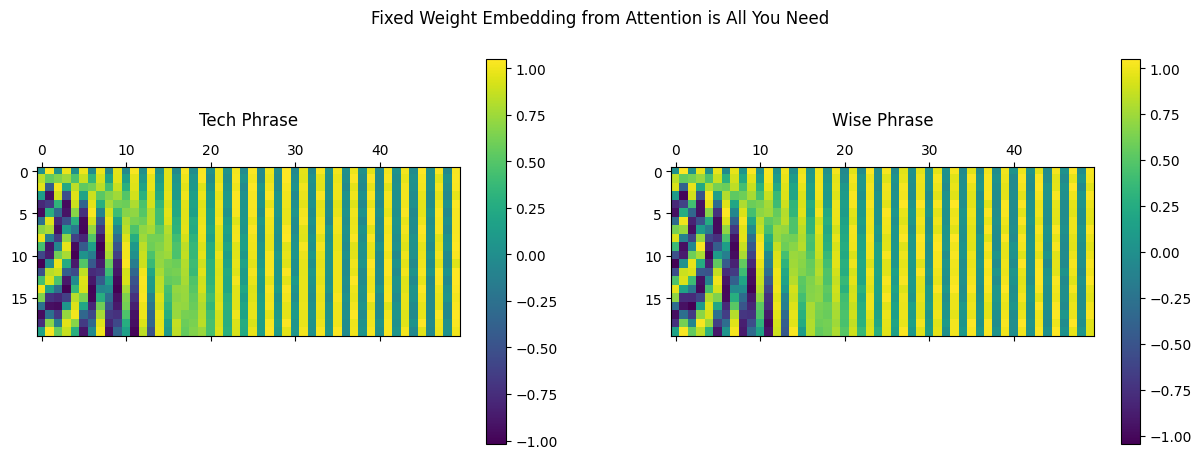

In [25]:
fig = plt.figure(figsize=(15, 5))    
title = ["Tech Phrase", "Wise Phrase"]
for i in range(2):
    ax = plt.subplot(1, 2, 1+i)
    matrix = tf.reshape(fixed_embedding[i, :, :], (sequence_length, final_output_len))
    cax = ax.matshow(matrix)
    plt.gcf().colorbar(cax)   
    plt.title(title[i], y=1.2)
fig.suptitle("Fixed Weight Embedding from Attention is All You Need")
plt.show()

## Implementing the Transformer Encoder from Scratch

- Reference: https://machinelearningmastery.com/implementing-the-transformer-encoder-from-scratch-in-tensorflow-and-keras/

### Normalization and Feed Forward layers

In [26]:
from tensorflow.keras.layers import LayerNormalization, Layer, Dense, ReLU, Dropout

# Implementing the Add & Norm Layer
class AddNormalization(Layer):
    def __init__(self, **kwargs):
        super(AddNormalization, self).__init__(**kwargs)
        self.layer_norm = LayerNormalization()  # Layer normalization layer

    def call(self, x, sublayer_x):
        # The sublayer input and output need to be of the same shape to be summed
        add = x + sublayer_x

        # Apply layer normalization to the sum
        return self.layer_norm(add)

# Implementing the Feed-Forward Layer
class FeedForward(Layer):
    def __init__(self, d_ff, d_model, **kwargs):
        super(FeedForward, self).__init__(**kwargs)
        self.fully_connected1 = Dense(d_ff)  # First fully connected layer
        self.fully_connected2 = Dense(d_model)  # Second fully connected layer
        self.activation = ReLU()  # ReLU activation layer

    def call(self, x):
        # The input is passed into the two fully-connected layers, with a ReLU in between
        x_fc1 = self.fully_connected1(x)

        return self.fully_connected2(self.activation(x_fc1))

### Positional Embedding layer

In [27]:
# Implementing the Postional encoding Layer
class PositionEmbeddingFixedWeights(Layer):
    def __init__(self, sequence_length, vocab_size, output_dim, **kwargs):
        super(PositionEmbeddingFixedWeights, self).__init__(**kwargs)
        word_embedding_matrix = self.get_position_encoding(vocab_size, output_dim) 
        # print("word_embedding_matrix", word_embedding_matrix.shape)  
        position_embedding_matrix = self.get_position_encoding(sequence_length, output_dim) 
        # print("position_embedding_matrix", position_embedding_matrix.shape)                                         
        self.word_embedding_layer = Embedding(
            input_dim=vocab_size, output_dim=output_dim,
            weights=[word_embedding_matrix],
            trainable=False # should be True ideally
        )
        self.position_embedding_layer = Embedding(
            input_dim=sequence_length, output_dim=output_dim,
            weights=[position_embedding_matrix],
            trainable=False
        )
             
    def get_position_encoding(self, seq_len, d, n=10000):
        P = np.zeros((seq_len, d))
        for k in range(seq_len):
            for i in np.arange(int(d/2)):
                denominator = np.power(n, 2*i/d)
                P[k, 2*i] = np.sin(k/denominator)
                P[k, 2*i+1] = np.cos(k/denominator)
        return P

    def call(self, inputs):        
        position_indices = tf.range(tf.shape(inputs)[-1])
        embedded_words = self.word_embedding_layer(inputs)
        # print("embedded_words", embedded_words.shape)
        embedded_indices = self.position_embedding_layer(position_indices)
        # print("embedded_indices", embedded_indices.shape)
        final_embeddings = embedded_words + embedded_indices
        # print("final_embeddings: ", final_embeddings.shape)
        return final_embeddings

### Encoder Layer

In [28]:
from tensorflow import math, matmul, reshape, shape, transpose, cast, float32
from keras import layers, Layer, activations

# Implementing the Scaled-Dot Product Attention
class DotProductAttention(Layer):
    def __init__(self, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)

    def call(self, queries, keys, values, d_k, mask=None):
        # Scoring the queries against the keys after transposing the latter, and scaling
        # print("query and key shape - DotProductAttention: ", queries.shape, keys.shape)
        scores = matmul(queries, keys, transpose_b=True) / math.sqrt(cast(d_k, float32))
        # print("Scores - DotProductAttention: ", scores.shape)

        # Apply mask to the attention scores
        if mask is not None:
            # print("Scores - DotProductAttention: ", scores.shape)
            # print("mask shape - DotProductAttention: ", mask.shape)
            scores += -1e9 * mask
            # print("scores.shape - DotProductAttention: ", scores.shape)

        # Computing the weights by a softmax operation
        weights = activations.softmax(scores)

        # Computing the attention by a weighted sum of the value vectors
        return matmul(weights, values)

In [29]:
# Implementing the Multi-Head Attention
class MultiHeadAttention(Layer):
    def __init__(self, h, d_k, d_v, d_model, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.attention = DotProductAttention()  # Scaled dot product attention
        self.heads = h  # Number of attention heads to use
        self.d_k = d_k  # Dimensionality of the linearly projected queries and keys
        self.d_v = d_v  # Dimensionality of the linearly projected values
        self.d_model = d_model  # Dimensionality of the model
        self.W_q = layers.Dense(d_k)  # Learned projection matrix for the queries
        self.W_k = layers.Dense(d_k)  # Learned projection matrix for the keys
        self.W_v = layers.Dense(d_v)  # Learned projection matrix for the values
        self.W_o = layers.Dense(d_model)  # Learned projection matrix for the multi-head output

    def reshape_tensor(self, x, heads, flag):
        if flag:
            # Tensor shape after reshaping and transposing: (batch_size, heads, seq_length, -1)
            x = reshape(x, shape=(shape(x)[0], shape(x)[1], heads, -1)) # shape here: (batch_size, seq_length, heads, , -1)
            x = transpose(x, perm=(0, 2, 1, 3))
        else:
            # Reverting the reshaping and transposing operations: (batch_size, seq_length, d_k)
            x = transpose(x, perm=(0, 2, 1, 3))
            x = reshape(x, shape=(shape(x)[0], shape(x)[1], -1))
        return x

    def call(self, queries, keys, values, mask=None):
        # Rearrange the queries to be able to compute all heads in parallel
        # print("queries shape: ", queries.shape, self.W_q(queries).shape)
        q_reshaped = self.reshape_tensor(self.W_q(queries), self.heads, True) # Shape of self.W_q(queries): (64, 5, 64)
        # print("q_reshaed shape: ", q_reshaped.shape)
        # Resulting tensor shape: (batch_size, heads, input_seq_length, -1)

        # Rearrange the keys to be able to compute all heads in parallel
        k_reshaped = self.reshape_tensor(self.W_k(keys), self.heads, True)
        # Resulting tensor shape: (batch_size, heads, input_seq_length, -1)

        # Rearrange the values to be able to compute all heads in parallel
        v_reshaped = self.reshape_tensor(self.W_v(values), self.heads, True)
        # Resulting tensor shape: (batch_size, heads, input_seq_length, -1)

        # Compute the multi-head attention output using the reshaped queries, keys and values
        o_reshaped = self.attention(q_reshaped, k_reshaped, v_reshaped, tf.constant(self.d_k), mask)
        # Resulting tensor shape: (batch_size, heads, input_seq_length, -1)

        # Rearrange back the output into concatenated form
        output = self.reshape_tensor(o_reshaped, self.heads, False)
        # Resulting tensor shape: (batch_size, input_seq_length, d_v)

        # Apply one final linear projection to the output to generate the multi-head attention
        # Resulting tensor shape: (batch_size, input_seq_length, d_model)
        return self.W_o(output)

In [30]:
from tensorflow.keras.layers import Input
from tensorflow.keras import Model

# Implementing the Encoder Layer
class EncoderLayer(Layer):
    def __init__(self, h, d_k, d_v, d_model, d_ff, rate, **kwargs):
        super(EncoderLayer, self).__init__(**kwargs)
        self.multihead_attention = MultiHeadAttention(h, d_k, d_v, d_model)
        self.dropout1 = Dropout(rate)
        self.add_norm1 = AddNormalization()
        self.feed_forward = FeedForward(d_ff, d_model)
        self.dropout2 = Dropout(rate)
        self.add_norm2 = AddNormalization()

    def call(self, x, padding_mask, training=None):
        # Multi-head attention layer
        multihead_output = self.multihead_attention(x, x, x, padding_mask)
        # Expected output shape = (batch_size, sequence_length, d_model)

        # Add in a dropout layer
        multihead_output = self.dropout1(multihead_output, training=training)

        # Followed by an Add & Norm layer
        addnorm_output = self.add_norm1(x, multihead_output)
        # Expected output shape = (batch_size, sequence_length, d_model)

        # Followed by a fully connected layer
        feedforward_output = self.feed_forward(addnorm_output)
        # Expected output shape = (batch_size, sequence_length, d_model)

        # Add in another dropout layer
        feedforward_output = self.dropout2(feedforward_output, training=training)

        # Followed by another Add & Norm layer
        return self.add_norm2(addnorm_output, feedforward_output)

# Implementing the Encoder
class Encoder(Layer):
    def __init__(self, vocab_size, sequence_length, h, d_k, d_v, d_model, d_ff, n, rate, **kwargs):
        super(Encoder, self).__init__(**kwargs)
        self.pos_encoding = PositionEmbeddingFixedWeights(sequence_length, vocab_size, d_model)
        self.dropout = Dropout(rate)
        self.encoder_layer = [EncoderLayer(h, d_k, d_v, d_model, d_ff, rate) for _ in range(n)]

    def call(self, input_sentence, padding_mask, training=True):
        # Generate the positional encoding
        pos_encoding_output = self.pos_encoding(input_sentence)
        # print("pos_encoding_output - Encoder: ", pos_encoding_output[0:5])
        # Expected output shape = (batch_size, sequence_length, d_model)

        # Add in a dropout layer
        x = self.dropout(pos_encoding_output, training=training)

        # Pass on the positional encoded values to each encoder layer
        for _, layer in enumerate(self.encoder_layer):
            x = layer(x, padding_mask, training=training)

        return x

In [31]:
from numpy import random

enc_vocab_size = 20 # Vocabulary size for the encoder
input_seq_length = 5  # Maximum length of the input sequence
h = 8  # Number of self-attention heads
d_k = 64  # Dimensionality of the linearly projected queries and keys
d_v = 64  # Dimensionality of the linearly projected values
d_ff = 2048  # Dimensionality of the inner fully connected layer
d_model = 512  # Dimensionality of the model sub-layers' outputs
n = 6  # Number of layers in the encoder stack

batch_size = 64  # Batch size from the training process
dropout_rate = 0.1  # Frequency of dropping the input units in the dropout layers

input_seq = random.random((batch_size, input_seq_length))

encoder = Encoder(enc_vocab_size, input_seq_length, h, d_k, d_v, d_model, d_ff, n, dropout_rate)
encoder(input_seq, None, training=True).shape

TensorShape([64, 5, 512])

## Implementing the Transformer Decoder from Scratch

- Reference: https://machinelearningmastery.com/implementing-the-transformer-decoder-from-scratch-in-tensorflow-and-keras/

In [32]:
from tensorflow.keras.layers import Layer, Dropout
 
# Implementing the Decoder Layer
class DecoderLayer(Layer):
    def __init__(self, h, d_k, d_v, d_model, d_ff, rate, **kwargs):
        super(DecoderLayer, self).__init__(**kwargs)
        self.multihead_attention1 = MultiHeadAttention(h, d_k, d_v, d_model)
        self.dropout1 = Dropout(rate)
        self.add_norm1 = AddNormalization()
        self.multihead_attention2 = MultiHeadAttention(h, d_k, d_v, d_model)
        self.dropout2 = Dropout(rate)
        self.add_norm2 = AddNormalization()
        self.feed_forward = FeedForward(d_ff, d_model)
        self.dropout3 = Dropout(rate)
        self.add_norm3 = AddNormalization()

    def call(self, x, encoder_output, lookahead_mask, padding_mask, training=None):
        # Multi-head attention layer
        # print("Decoder Input: ", x.shape)
        # print("lookahead mask: ", lookahead_mask.shape)
        multihead_output1 = self.multihead_attention1(x, x, x, lookahead_mask)
        # Expected output shape = (batch_size, sequence_length, d_model)

        # Add in a dropout layer
        multihead_output1 = self.dropout1(multihead_output1, training=training)

        # Followed by an Add & Norm layer
        addnorm_output1 = self.add_norm1(x, multihead_output1)
        # Expected output shape = (batch_size, sequence_length, d_model)

        # Followed by another multi-head attention layer
        multihead_output2 = self.multihead_attention2(addnorm_output1, encoder_output, encoder_output, padding_mask)

        # Add in another dropout layer
        multihead_output2 = self.dropout2(multihead_output2, training=training)

        # Followed by another Add & Norm layer
        addnorm_output2 = self.add_norm2(addnorm_output1, multihead_output2)

        # Followed by a fully connected layer
        feedforward_output = self.feed_forward(addnorm_output2)
        # Expected output shape = (batch_size, sequence_length, d_model)

        # Add in another dropout layer
        feedforward_output = self.dropout3(feedforward_output, training=training)

        # Followed by another Add & Norm layer
        return self.add_norm3(addnorm_output2, feedforward_output)

# Implementing the Decoder
class Decoder(Layer):
    def __init__(self, vocab_size, sequence_length, h, d_k, d_v, d_model, d_ff, n, rate, **kwargs):
        super(Decoder, self).__init__(**kwargs)
        self.pos_encoding = PositionEmbeddingFixedWeights(sequence_length, vocab_size, d_model)
        self.dropout = Dropout(rate)
        self.decoder_layer = [DecoderLayer(h, d_k, d_v, d_model, d_ff, rate) for _ in range(n)]

    def call(self, output_target, encoder_output, lookahead_mask, padding_mask, training=None):
        # Generate the positional encoding
        pos_encoding_output = self.pos_encoding(output_target)
        # print("pos_encoding_output - Decoder: ", pos_encoding_output)
        # Expected output shape = (number of sentences, sequence_length, d_model)

        # Add in a dropout layer
        
        x = self.dropout(pos_encoding_output, training=training)

        # Pass on the positional encoded values to each encoder layer
        for _, layer in enumerate(self.decoder_layer):
            x = layer(x, encoder_output, lookahead_mask, padding_mask, training=training)

        return x

In [33]:
from numpy import random

dec_vocab_size = 20  # Vocabulary size for the decoder
input_seq_length = 5  # Maximum length of the input sequence
h = 8  # Number of self-attention heads
d_k = 64  # Dimensionality of the linearly projected queries and keys
d_v = 64  # Dimensionality of the linearly projected values
d_ff = 2048  # Dimensionality of the inner fully connected layer
d_model = 512  # Dimensionality of the model sub-layers' outputs
n = 6  # Number of layers in the decoder stack

batch_size = 64  # Batch size from the training process
dropout_rate = 0.1  # Frequency of dropping the input units in the dropout layers

input_seq = random.random((batch_size, input_seq_length))
enc_output = random.random((batch_size, input_seq_length, d_model))

decoder = Decoder(dec_vocab_size, input_seq_length, h, d_k, d_v, d_model, d_ff, n, dropout_rate)
decoder(input_seq, enc_output, None, None, training=True).shape

TensorShape([64, 5, 512])

## Implementing the Joining of  Transformer Encoder and Decoder

- Reference: https://machinelearningmastery.com/joining-the-transformer-encoder-and-decoder-and-masking/

### Creating a Padding Mask

In [34]:
from tensorflow import math, cast, float32

def padding_mask(input):
    # Create mask which marks the zero padding values in the input by a 1
    mask = math.equal(input, 0)
    mask = cast(mask, float32)

    return mask

In [35]:
from numpy import array

input = array([1, 2, 3, 4, 0, 0, 0])
padding_mask(input)

<tf.Tensor: shape=(7,), dtype=float32, numpy=array([0., 0., 0., 0., 1., 1., 1.], dtype=float32)>

### Creating a Look-Ahead Mask

In [36]:
from tensorflow import linalg, ones

def lookahead_mask(shape):
    # Mask out future entries by marking them with a 1.0
    mask = 1 - linalg.band_part(ones((shape, shape)), -1, 0)

    return mask

In [37]:
lookahead_mask(5)

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[0., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1.],
       [0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0.]], dtype=float32)>

### Joining the Transformer Encoder and Decoder

In [38]:
from tensorflow import math, cast, float32, linalg, ones, maximum, newaxis
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense

class TransformerModel(Model):
    def __init__(self, enc_vocab_size, dec_vocab_size, enc_seq_length, dec_seq_length, h, d_k, d_v, d_model, d_ff_inner, n, rate, **kwargs):
        super(TransformerModel, self).__init__(**kwargs)

        # Set up the encoder
        self.encoder = Encoder(enc_vocab_size, enc_seq_length, h, d_k, d_v, d_model, d_ff_inner, n, rate)

        # Set up the decoder
        self.decoder = Decoder(dec_vocab_size, dec_seq_length, h, d_k, d_v, d_model, d_ff_inner, n, rate)

        # Define the final dense layer
        self.model_last_layer = Dense(dec_vocab_size)

    def padding_mask(self, input):
        # Create mask which marks the zero padding values in the input by a 1.0
        mask = math.equal(input, 0)
        mask = cast(mask, float32)

        # The shape of the mask should be broadcastable to the shape
        # of the attention weights that it will be masking later on
        return mask[:, newaxis, newaxis, :]

    def lookahead_mask(self, shape):
        # Mask out future entries by marking them with a 1.0
        mask = 1 - linalg.band_part(ones((shape, shape)), -1, 0)

        return mask

    def call(self, encoder_input, decoder_input, training=None):

        # Create padding mask to mask the encoder inputs and the encoder outputs in the decoder
        enc_padding_mask = self.padding_mask(encoder_input)
        # print("enc_padding_mask: ", enc_padding_mask.shape)

        # Create and combine padding and look-ahead masks to be fed into the decoder
        dec_in_padding_mask = self.padding_mask(decoder_input)
        # print("dec_in_padding_mask - TransformerModel: ",  dec_in_padding_mask)
        dec_in_lookahead_mask = self.lookahead_mask(decoder_input.shape[1])
        # print("dec_in_lookahead_mask - TransformerModel: ",  dec_in_lookahead_mask.shape)
        dec_in_lookahead_mask = maximum(dec_in_padding_mask, dec_in_lookahead_mask)
        # print("dec_in_lookahead_mask shape - TransformerModel: ", dec_in_lookahead_mask)

        # Feed the input into the encoder
        # print("encoder_input - TransformerModel: ", encoder_input[0:5])
        encoder_output = self.encoder(encoder_input, enc_padding_mask, training=training)
        # print("encoder_output - TransformerModel: ", encoder_output.shape)

        # Feed the encoder output into the decoder
        # print("decoder_input - TransformerModel: ", decoder_input)
        decoder_output = self.decoder(decoder_input, encoder_output, dec_in_lookahead_mask, enc_padding_mask, training=training)

        # Pass the decoder output through a final dense layer
        model_output = self.model_last_layer(decoder_output)

        # print("model_output: ", model_output.shape)

        return model_output

In [39]:
enc_vocab_size = 20 # Vocabulary size for the encoder
dec_vocab_size = 20 # Vocabulary size for the decoder

enc_seq_length = 5  # Maximum length of the input sequence
dec_seq_length = 7  # Maximum length of the target sequence

h = 8  # Number of self-attention heads
d_k = 64  # Dimensionality of the linearly projected queries and keys
d_v = 64  # Dimensionality of the linearly projected values
d_ff = 2048  # Dimensionality of the inner fully connected layer
d_model = 512  # Dimensionality of the model sub-layers' outputs
n = 6  # Number of layers in the encoder stack

dropout_rate = 0.1  # Frequency of dropping the input units in the dropout layers

batch_size = 64

encoder_input = random.random((batch_size, enc_seq_length))
decoder_input = random.random((batch_size, dec_seq_length))

# Create model
training_model = TransformerModel(enc_vocab_size, dec_vocab_size, enc_seq_length, dec_seq_length, h, d_k, d_v, d_model, d_ff, n, dropout_rate)
training_model(encoder_input, decoder_input, training=True).shape

TensorShape([64, 7, 20])

## Training the Transformer Model

- Reference: https://machinelearningmastery.com/training-the-transformer-model/

### Preparing the Training Dataset

In [40]:
from pickle import load
from numpy.random import shuffle
from tensorflow.keras.layers import TextVectorization

class PrepareDataset:
	def __init__(self, **kwargs):
		super(PrepareDataset, self).__init__(**kwargs)
		self.n_sentences = 10000  # Number of sentences to include in the dataset
		self.train_split = 0.9  # Ratio of the training data split

	# Fit a tokenizer
	def create_tokenizer(self, dataset):
		# Create the TextVectorization layer
		tokenizer = TextVectorization()
		# Train the layer to create a dictionary
		tokenizer.adapt(dataset)

		return tokenizer

	def find_seq_length(self, dataset):
		return max(len(seq.split()) for seq in dataset)

	def find_vocab_size(self, tokenizer):
		return len(tokenizer.get_vocabulary()) + 1

	def __call__(self, filename, **kwargs):
		# Load a clean dataset
		clean_dataset = load(open(filename, 'rb'))
		# print("clean_dataset: ", clean_dataset.shape)

		# Reduce dataset size
		dataset = clean_dataset[:self.n_sentences, :]
		# print("Dataset: ", dataset)

		# Include start and end of string tokens
		for i in range(dataset[:, 0].size):
			dataset[i, 0] = "<SOS> " + dataset[i, 0] + " <EOS>"
			dataset[i, 1] = "<SOS> " + dataset[i, 1] + " <EOS>"

		# Random shuffle the dataset
		shuffle(dataset)

		# Split the dataset
		train = dataset[:int(self.n_sentences * self.train_split)]
		# print(train[:, 0])

		# Prepare tokenizer for the encoder input
		enc_tokenizer = self.create_tokenizer(train[:, 0])
		# print(len(enc_tokenizer.get_vocabulary()))
		enc_seq_length = self.find_seq_length(train[:, 0])
		# print("enc_seq_length: ", enc_seq_length)
		enc_vocab_size = self.find_vocab_size(enc_tokenizer)
		# print("enc_vocab_size: ", enc_vocab_size)

		# Encode and pad the input sequences
		trainX = enc_tokenizer(train[:, 0])
		

		# Prepare tokenizer for the decoder input
		dec_tokenizer = self.create_tokenizer(train[:, 1])
		dec_seq_length = self.find_seq_length(train[:, 1])  # + 1  Why did I add 1 here?
		dec_vocab_size = self.find_vocab_size(dec_tokenizer)

		# Encode and pad the input sequences
		trainY = dec_tokenizer(train[:, 1])

		return trainX, trainY, train, enc_seq_length, dec_seq_length, enc_vocab_size, dec_vocab_size

In [41]:
filename = './english-german-both.pkl'
dataset = PrepareDataset()

trainX, trainY, train_orig, enc_seq_length, dec_seq_length, enc_vocab_size, dec_vocab_size = dataset(filename)
 
print(train_orig[0, 0], '\n', trainX[0, :])
print('Encoder sequence length:', enc_seq_length)
print(train_orig[0, 1], '\n', trainY[0, :])
print('Decoder sequence length:', dec_seq_length)
print("enc_vocab_size: ", enc_vocab_size)
print("dec_vocab_size: ", dec_vocab_size)
print("trainX : ", trainX)
print("trainY : ", trainY)

<SOS> are you excited <EOS> 
 tf.Tensor([  2  17   6 804   3   0   0], shape=(7,), dtype=int64)
Encoder sequence length: 7
<SOS> seid ihr aufgeregt <EOS> 
 tf.Tensor([  2  74  25 973   3   0   0   0   0   0   0   0], shape=(12,), dtype=int64)
Decoder sequence length: 12
enc_vocab_size:  2314
dec_vocab_size:  3694
trainX :  tf.Tensor(
[[  2  17   6 ...   3   0   0]
 [  2   4  29 ... 189   3   0]
 [  2  57   5 ...   3   0   0]
 ...
 [  2  48  52 ...   3   0   0]
 [  2  41  94 ...   0   0   0]
 [  2   4  96 ...   3   0   0]], shape=(9000, 7), dtype=int64)
trainY :  tf.Tensor(
[[  2  74  25 ...   0   0   0]
 [  2   4  13 ...   0   0   0]
 [  2  47   6 ...   0   0   0]
 ...
 [  2   4  46 ...   0   0   0]
 [  2  56  24 ...   0   0   0]
 [  2   4 106 ...   0   0   0]], shape=(9000, 12), dtype=int64)


###  Model

In [42]:
# visualise the learning rate
warmup_steps = 4000
d_model = 512
lr = []
for step_num in range(1, 10000):
    arg1 = step_num ** -0.5
    arg2 = step_num * (warmup_steps ** -1.5)
    x = (d_model ** -0.5) * math.minimum(arg1, arg2)
    lr.append(x)

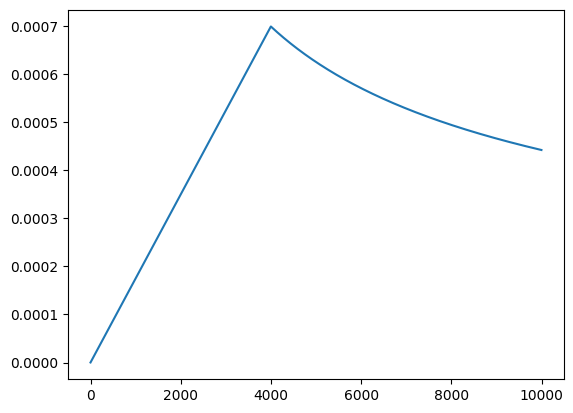

In [43]:
plt.plot(lr);

In [44]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
from tensorflow.keras.metrics import Mean
from tensorflow import data, train, math, reduce_sum, cast, equal, argmax, float32, GradientTape, TensorSpec, function, int64
from keras.losses import sparse_categorical_crossentropy
from time import time

# Define the model parameters
h = 8  # Number of self-attention heads
d_k = 64  # Dimensionality of the linearly projected queries and keys
d_v = 64  # Dimensionality of the linearly projected values
d_model = 512  # Dimensionality of model layers' outputs
d_ff = 2048  # Dimensionality of the inner fully connected layer
n = 6  # Number of layers in the encoder stack

# Define the training parameters
epochs = 2
batch_size = 64
beta_1 = 0.9
beta_2 = 0.98
epsilon = 1e-9
dropout_rate = 0.1

# Implementing a learning rate scheduler
class LRScheduler(LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000, **kwargs):
        super(LRScheduler, self).__init__(**kwargs)

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        
        # Linearly increasing the learning rate for the first warmup_steps, and decreasing it thereafter
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

# Instantiate an Adam optimizer
optimizer = Adam(LRScheduler(d_model), beta_1, beta_2, epsilon)

# Prepare the training and test splits of the dataset
filename = './english-german-both.pkl'
dataset = PrepareDataset()
trainX, trainY, train_orig, enc_seq_length, dec_seq_length, enc_vocab_size, dec_vocab_size = dataset(filename)
print("enc_vocab_size: ", enc_vocab_size)
print("dec_vocab_size: ", dec_vocab_size)
print("enc_seq_length: ", enc_seq_length)
print("dec_seq_length: ", dec_seq_length)
print("trainX: ", trainX[0:5, :])
print("trainY: ", trainY[0:5, :])

# Prepare the dataset batches
train_dataset = data.Dataset.from_tensor_slices((trainX, trainY))
train_dataset = train_dataset.batch(batch_size)

# Create model
training_model = TransformerModel(enc_vocab_size, dec_vocab_size, enc_seq_length, dec_seq_length, h, d_k, d_v, d_model, d_ff, n, dropout_rate)

# Defining the loss function
def loss_fcn(target, prediction):
    # Create mask so that the zero padding values are not included in the computation of loss
    padding_mask = math.logical_not(equal(target, 0))
    padding_mask = cast(padding_mask, float32)

    # print("padding_mask: ", padding_mask)

    # Compute a sparse categorical cross-entropy loss on the unmasked values
    loss = sparse_categorical_crossentropy(target, prediction, from_logits=True) * padding_mask

    # print("loss: ", loss)

    # Compute the mean loss over the unmasked values
    return reduce_sum(loss) / reduce_sum(padding_mask)


# Defining the accuracy function
def accuracy_fcn(target, prediction):
    # print(target)
    # print(prediction)
    # Create mask so that the zero padding values are not included in the computation of accuracy
    padding_mask = math.logical_not(equal(target, 0))

    # Find equal prediction and target values, and apply the padding mask
    # print("argmax(prediction, axis=2): ", argmax(prediction, axis=2))
    accuracy = equal(target, argmax(prediction, axis=2))
    # print("accuracy: ", accuracy)
    accuracy = math.logical_and(padding_mask, accuracy)

    # Cast the True/False values to 32-bit-precision floating-point numbers
    padding_mask = cast(padding_mask, float32)
    accuracy = cast(accuracy, float32)

    # Compute the mean accuracy over the unmasked values
    return reduce_sum(accuracy) / reduce_sum(padding_mask)


# Include metrics monitoring
train_loss = Mean(name='train_loss')
train_accuracy = Mean(name='train_accuracy')

# # Create a checkpoint object and manager to manage multiple checkpoints
# ckpt = train.Checkpoint(model=training_model, optimizer=optimizer)
# ckpt_manager = train.CheckpointManager(ckpt, "./checkpoints", max_to_keep=3)

# Speeding up the training process
# @function
def train_step(encoder_input, decoder_input, decoder_output):
    with GradientTape() as tape:

        # Run the forward pass of the model to generate a prediction
        prediction = training_model(encoder_input, decoder_input, training=True)
        # print("prediction: ", prediction)
        # print("decoder_output: ", decoder_output)

        # Compute the training loss
        loss = loss_fcn(decoder_output, prediction)

        # print("loss: ", loss)

        # Compute the training accuracy
        accuracy = accuracy_fcn(decoder_output, prediction)

    # print("train step: ", decoder_output)
    # print("train step: ", prediction)
    # print('loss: ', loss)
    # print('accuracy: ', accuracy)

    # Retrieve gradients of the trainable variables with respect to the training loss
    gradients = tape.gradient(loss, training_model.trainable_weights)

    # Update the values of the trainable variables by gradient descent
    optimizer.apply_gradients(zip(gradients, training_model.trainable_weights))

    train_loss(loss)
    train_accuracy(accuracy)


for epoch in range(epochs):

    train_loss.reset_state()
    train_accuracy.reset_state()

    print("\nStart of epoch %d" % (epoch + 1))

    start_time = time()

    # Iterate over the dataset batches
    for step, (train_batchX, train_batchY) in enumerate(train_dataset):
        # print("step value: ", step)

        # Define the encoder and decoder inputs, and the decoder output
        encoder_input = train_batchX[:, 1:]
        # print("encoder_input: ", encoder_input[0:5])
        
        decoder_input = train_batchY[:, :-1]
        # print("decoder_input: ", decoder_input[0:5])

        decoder_output = train_batchY[:, 1:]
        # print("decoder_output: ", decoder_output[0:5])

        train_step(encoder_input, decoder_input, decoder_output)

        if step % 50 == 0:
            print(f'Epoch {epoch + 1} Step {step} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
            print("Samples so far: %s" % ((step + 1) * batch_size))

    # Print epoch number and loss value at the end of every epoch
    print("Epoch %d: Training Loss %.4f, Training Accuracy %.4f" % (epoch + 1, train_loss.result(), train_accuracy.result()))

    # # Save a checkpoint after every five epochs
    # if (epoch + 1) % 5 == 0:
    #     save_path = ckpt_manager.save()
    #     print("Saved checkpoint at epoch %d" % (epoch + 1))

print("Total time taken: %.2fs" % (time() - start_time))

enc_vocab_size:  2322
dec_vocab_size:  3685
enc_seq_length:  7
dec_seq_length:  12
trainX:  tf.Tensor(
[[   2   11 1347    3    0    0    0]
 [   2   36    9  135  291    3    0]
 [   2   49 1352    3    0    0    0]
 [   2   11    9 2184    3    0    0]
 [   2   11   38  194    3    0    0]], shape=(5, 7), dtype=int64)
trainY:  tf.Tensor(
[[   2    4   12 1371    3    0    0    0    0    0    0    0]
 [   2  692  245    3    0    0    0    0    0    0    0    0]
 [   2    5 3214    3    0    0    0    0    0    0    0    0]
 [   2    4   12 3373    3    0    0    0    0    0    0    0]
 [   2    4   63    9 1392    3    0    0    0    0    0    0]], shape=(5, 12), dtype=int64)

Start of epoch 1
Epoch 1 Step 0 Loss 8.2881 Accuracy 0.0034
Samples so far: 64
Epoch 1 Step 50 Loss 7.6197 Accuracy 0.1389
Samples so far: 3264
Epoch 1 Step 100 Loss 7.0468 Accuracy 0.1794
Samples so far: 6464


2025-07-31 05:30:56.342132: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1: Training Loss 6.7271, Training Accuracy 0.1997

Start of epoch 2
Epoch 2 Step 0 Loss 5.7070 Accuracy 0.2847
Samples so far: 64
Epoch 2 Step 50 Loss 5.4454 Accuracy 0.2723
Samples so far: 3264
Epoch 2 Step 100 Loss 5.2764 Accuracy 0.2831
Samples so far: 6464
Epoch 2: Training Loss 5.1533, Training Accuracy 0.2907
Total time taken: 1280.61s


2025-07-31 05:52:16.960150: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# Acknowledgment

- Thank You [Machine Learning Mastery](https://machinelearningmastery.com/) for the wonderfull tutorials and resources on Transformers.